<a href="https://colab.research.google.com/github/alvinak2/green-watt/blob/main/greenwatt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
df = pd.read_csv("train.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["turbine_id_code"] = df["turbine_id"].astype("category").cat.codes

TARGET = next((c for c in ["target", "Target", "power_output", "power", "Power"] if c in df.columns), None)
if TARGET is None:
    raise ValueError("No target column found — please specify your target column name")

df.head()

,timestamp,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,reactive_power,wind_direction_raw,wind_speed_raw,wind_speed_turbulence,turbine_id,Target,turbine_id_code
0,2021-02-19 20:18:00,816.636759,834.917206,31.694380,1159.616602,65.954214,917.897085,31.881972,31.504713,141.457644,165.501518,280.864782,7.057000,0.544082,Turbine_108,47.582787,4
1,2021-04-27 04:55:00,419.107829,421.050873,12.894948,928.747996,59.571319,445.554250,32.423705,32.755770,89.186457,113.835236,299.552460,5.474937,0.469031,Turbine_18,46.070328,12
2,2021-01-25 06:26:00,1303.530558,1337.566142,16.648388,1201.219775,61.270498,1364.716003,11.446849,18.332985,230.622309,281.452253,84.960106,8.092457,0.622318,Turbine_105,39.989236,3
3,2021-10-30 03:47:00,61.494872,53.481008,28.388141,769.806122,40.674348,14.324897,34.253204,32.662889,66.211015,75.017531,87.261119,4.071032,0.760719,Turbine_15,46.056587,10
4,2021-03-15 00:39:00,593.514364,611.659108,31.519527,1046.916768,64.341763,599.020172,32.405586,31.466387,137.163938,160.202421,313.724818,6.357943,0.346068,Turbine_01,54.346095,0


In [3]:
if "wind_speed" in df.columns:
    df["wind_speed_cubed"] = df["wind_speed"] ** 3

sensors = [c for c in ["wind_speed", "generator_speed", TARGET, "ambient_temp"] if c in df.columns]
for s in sensors:
    shifted_s = df.groupby("turbine_id_code")[s].shift(1)
    df[f"{s}_lag1"] = shifted_s
    df[f"{s}_roll3_mean"] = shifted_s.rolling(3, min_periods=1).mean().reset_index(level=0, drop=True)
    df[f"{s}_roll3_std"] = shifted_s.rolling(3, min_periods=1).std().reset_index(level=0, drop=True)
    df[f"{s}_roll3_min"] = shifted_s.rolling(3, min_periods=1).min().reset_index(level=0, drop=True)
    df[f"{s}_roll3_max"] = shifted_s.rolling(3, min_periods=1).max().reset_index(level=0, drop=True)

df["hour"] = df["timestamp"].dt.hour
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

df['day_of_week'] = df['timestamp'].dt.dayofweek
df["day_of_week_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
df["day_of_week_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7)

df['month'] = df['timestamp'].dt.month
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

if "wind_speed" in df.columns and "generator_speed" in df.columns:
    df['wind_x_generator_speed'] = df['wind_speed'] * df['generator_speed']

df = df.dropna().reset_index(drop=True)

print("Feature engineering complete. DataFrame shape:", df.shape)
df.head()

Feature engineering complete. DataFrame shape: (909585, 36)


,timestamp,active_power_calculated_by_converter,active_power_raw,ambient_temperature,generator_speed,generator_winding_temp_max,grid_power10min_average,nc1_inside_temp,nacelle_temp,reactice_power_calculated_by_converter,...,Target_roll3_max,hour,hour_sin,hour_cos,day_of_week,day_of_week_sin,day_of_week_cos,month,month_sin,month_cos
0,2021-05-17 00:45:00,963.812815,995.340871,32.155075,1191.258521,68.535469,996.888784,33.537125,32.077898,177.889793,...,54.346095,0,0.000000e+00,1.000000e+00,0,0.000000,1.000000,5,5.000000e-01,-8.660254e-01
1,2021-06-02 12:26:00,365.782102,368.365682,17.917588,815.032572,56.779894,199.450116,31.273330,33.382902,84.742714,...,48.529146,12,1.224647e-16,-1.000000e+00,2,0.974928,-0.222521,6,1.224647e-16,-1.000000e+00
2,2021-06-25 18:14:00,1985.419047,1861.532645,33.218669,1197.411060,84.871396,1820.152344,31.100848,35.181659,34.773197,...,47.947959,18,-1.000000e+00,-1.836970e-16,4,-0.433884,-0.900969,6,1.224647e-16,-1.000000e+00
3,2021-01-07 15:08:00,464.462184,468.272792,16.461959,961.838460,47.349640,263.790268,32.873905,29.712873,96.051526,...,47.582787,15,-7.071068e-01,-7.071068e-01,3,0.433884,-0.900969,1,5.000000e-01,8.660254e-01
4,2021-09-05 22:41:00,173.243149,163.915403,16.196406,769.830795,55.514864,312.095520,32.178228,31.555378,92.743200,...,46.210665,22,-5.000000e-01,8.660254e-01,6,-0.781831,0.623490,9,-1.000000e+00,-1.836970e-16


In [4]:
FEATURES = [c for c in df.select_dtypes(include=[np.number]).columns if c != TARGET]

train_size = int(len(df) * 0.8)
val_size = int(len(df) * 0.9)

train_df = df.iloc[:train_size]
val_df   = df.iloc[train_size:val_size]
test_df  = df.iloc[val_size:]

X_train, y_train = train_df[FEATURES], train_df[TARGET]
X_val, y_val     = val_df[FEATURES], val_df[TARGET]
X_test, y_test   = test_df[FEATURES], test_df[TARGET]

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (727668, 33)
Validation shape: (90958, 33)
Test shape: (90959, 33)


In [5]:
params = {
    "objective": "regression_l1",
    "metric": "rmse",
    "learning_rate": 0.03,
    "num_leaves": 40,
    "lambda_l1": 0.1,
    "lambda_l2": 0.1,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "verbose": -1,
    "n_jobs": -1,
    "seed": 42,
}

train_data = lgb.Dataset(X_train, label=y_train)
val_data   = lgb.Dataset(X_val, label=y_val, reference=train_data)

model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, val_data],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(100, verbose=True), lgb.log_evaluation(100)]
)

Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 1.4374	valid_1's rmse: 1.42731
[200]	training's rmse: 1.1571	valid_1's rmse: 1.14515
[300]	training's rmse: 1.08246	valid_1's rmse: 1.06906
[400]	training's rmse: 1.03829	valid_1's rmse: 1.02303
[500]	training's rmse: 1.0162	valid_1's rmse: 1.00042
[600]	training's rmse: 0.997049	valid_1's rmse: 0.980224
[700]	training's rmse: 0.983285	valid_1's rmse: 0.966161
[800]	training's rmse: 0.972162	valid_1's rmse: 0.954889
[900]	training's rmse: 0.962737	valid_1's rmse: 0.94569
[1000]	training's rmse: 0.953064	valid_1's rmse: 0.936189
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.953064	valid_1's rmse: 0.936189


In [7]:
def evaluate(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{name:<12} RMSE: {rmse:.3f}  MAE: {mae:.3f}  R²: {r2:.3f}")

val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

evaluate("Validation", y_val, val_preds)
evaluate("Test", y_test, test_preds)

Validation   RMSE: 0.936  MAE: 0.621  R²: 0.872
Test         RMSE: 0.936  MAE: 0.620  R²: 0.872


--- Model Analysis: Feature Importance ---


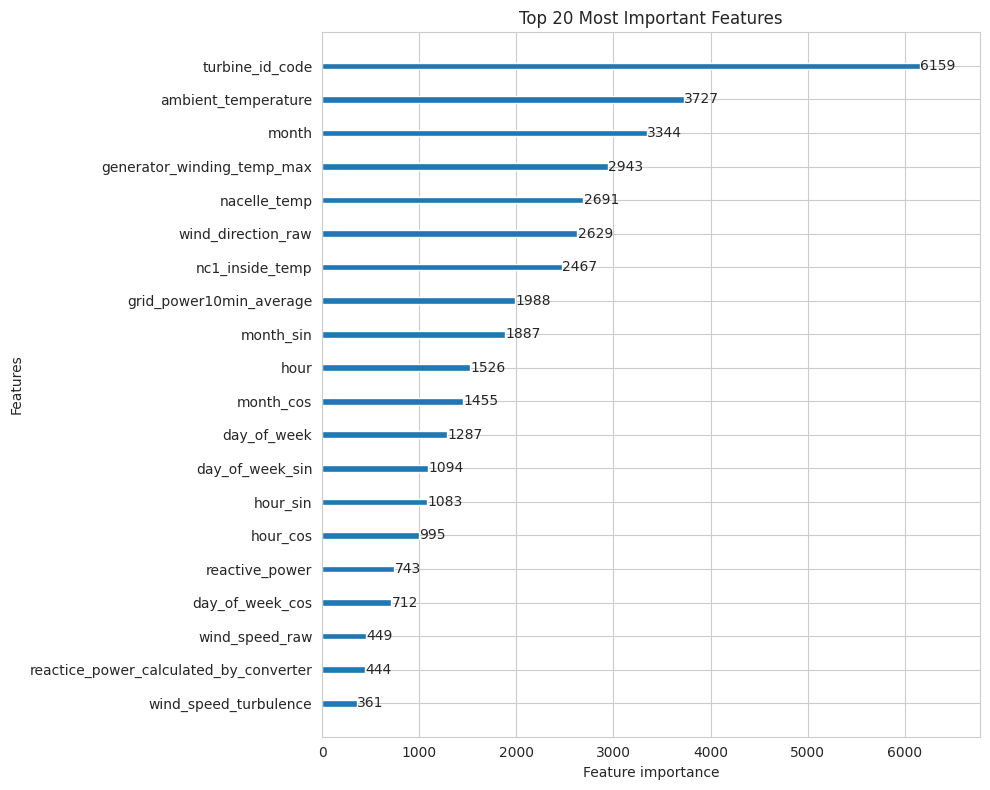

In [8]:
print("--- Model Analysis: Feature Importance ---")

lgb.plot_importance(
    model,
    max_num_features=20,
    figsize=(10, 8),
    title="Top 20 Most Important Features"
)
plt.tight_layout()
plt.show()

--- Model Analysis: Residuals ---


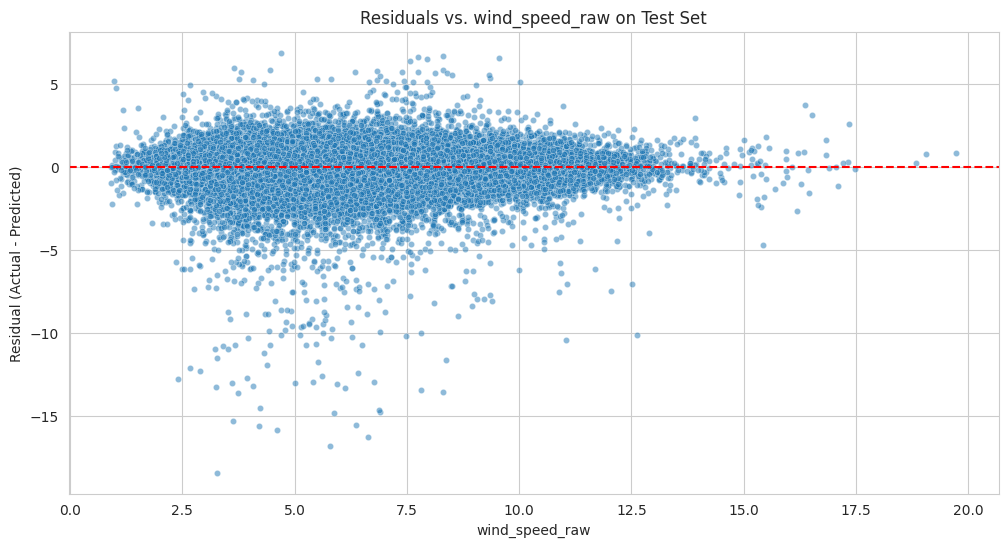

In [12]:
print("--- Model Analysis: Residuals ---")

WIND_SPEED_COL = 'wind_speed_raw'

test_df_analysis = test_df.copy()
test_df_analysis['prediction'] = test_preds
test_df_analysis['residual'] = test_df_analysis[TARGET] - test_df_analysis['prediction']

plt.figure(figsize=(12, 6))

sns.scatterplot(data=test_df_analysis, x=WIND_SPEED_COL, y='residual', alpha=0.5, s=20)

plt.axhline(0, color='red', linestyle='--')
plt.title(f'Residuals vs. {WIND_SPEED_COL} on Test Set')
plt.xlabel(WIND_SPEED_COL)
plt.ylabel('Residual (Actual - Predicted)')
plt.show()

In [ ]:
model.save_model("greenwatt_lgbm_model_v2.txt")
joblib.dump(model, "greenwatt_lgbm_model_v2.pkl")

print("✅ Model v2 saved successfully!")